# **Laboratory 4:** Extraction and handling of visual information

Extracting features is a common initial step to obtain and handle visual information. When it's about embedded systems, feature extraction, image processing, and information persistence must be performed efficiently due to the low resources inside embedded devices. Therefore, it's always useful to have and compare several feature extraction methods according to your project's needs.

<center>
<img src='https://drive.google.com/uc?id=1dinxlUbEiKZmxoPhSIQLYP_tUL8FI5wZ' width='30%'></center>

Once you obtain and save features, you can use them to make comparisons against the features of new images. This approach is also known as **Content-Based Image Retrieval** (CBIR), and it helps a lot to query databases with images, e.g. to find a person. Therefore, this laboratory will be oriented towards the implementation of CBIR systems and image databases. You will see these are useful in the majority of projects. The present notebook contains a detailed explanation to implement ORB, but the process to implement other methods (AKAZE, KAZE, AGAST, BRISK, SIFT, and SURF) can be found [here](https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html). Additionally, the theoretical explanation of ORB, SIFT, SURF is shared [here](https://youtu.be/tr2ookESvnU). Make sure to watch the video first to speed up the selection of parameters when implementing the methods.

## **A. Feature Extraction and Query**

Finding keypoints, also known as features or corners, is quite useful for numerous applications that range from tracking of locations to object detection. ORB, AKAZE, KAZE, AGAST, BRISK, SIFT, and SURF are amongst the most used traditional feature extraction algorithms, and most of them have their implementation available in OpenCV. As mentioned above, once you obtain the keypoints of one image, you're able to compare them with the keypoints from another image to find matches. In the following cells, you will see an example with ORB (Oriented FAST and Rotated BRIEF) to detect the presence of specific cars in two images, and you will have to implement a similar strategy with other algorithms available in OpenCV for different applications.

### 0. Image pyramids
Before starting with ORB, let's take a look at how downsampling works with images.

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'marketingsimulator.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


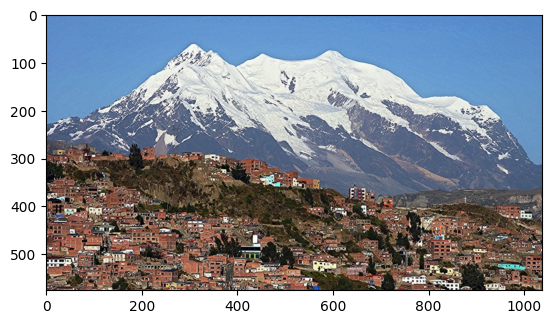

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, requests

%matplotlib inline

# Download an image from the Internet
img_data = requests.get("https://marketingsimulator.net/asaucedo/wp-content/uploads/sites/187/2016/07/ILLIMANI1-1038x576.jpg" , verify=False).content
with open('ILLIMANI1-1038x576.jpg', 'wb') as handler:
    handler.write(img_data)

# Read in the image
image0 = cv2.imread('ILLIMANI1-1038x576.jpg')

# Change color to RGB (from BGR)
image0 = cv2.cvtColor(image0, cv2.COLOR_BGR2RGB)

plt.imshow(image0)

Then, we will successively apply `cv2.pyrDown()` to the base image and display results.

(576.0, 0.0)

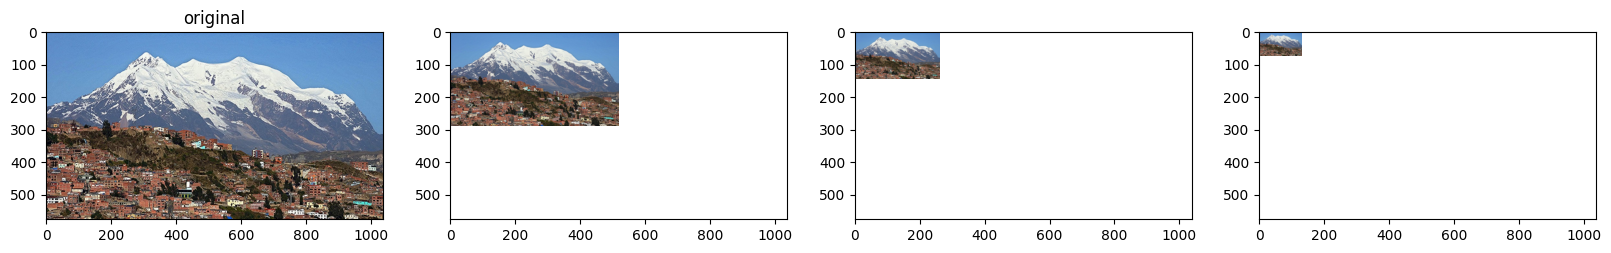

In [ ]:
level_1 = cv2.pyrDown(image0)
level_2 = cv2.pyrDown(level_1)
level_3 = cv2.pyrDown(level_2)

# Display the images
f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,10))

ax1.set_title('original')
ax1.imshow(image0)

ax2.imshow(level_1)
ax2.set_xlim([0, image0.shape[1]])
ax2.set_ylim([image0.shape[0], 0])

ax3.imshow(level_2)
ax3.set_xlim([0, image0.shape[1]])
ax3.set_ylim([image0.shape[0], 0])

ax4.imshow(level_3)
ax4.set_xlim([0, image0.shape[1]])
ax4.set_ylim([image0.shape[0], 0])

As you can see, every time we apply `cv2.pyrDown()`, we divide the image into two. Inside the operation, a four-pixel box now becomes one pixel with the average intensity. You can relate this with max-pooling operations and as an optimal way to process big images. However, the more you reduce the image, the more you lose visual information. In contrast, you will require less bytes to save the images.


### 1. Loading images and importing resources

While ORB can work with a single image to obtain features, it's better to apply it to two or more images to find matches. This will help you determine if there are similar (or same) objects in these images. If we focus on two images to query the presence of objects, a common strategy is to use a small image with the specific object you aim to find as a template, and a larger image to query with many objects. The small image is known as *query image*, meanwhile the large image is known as *training image*.

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kintan.tv'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


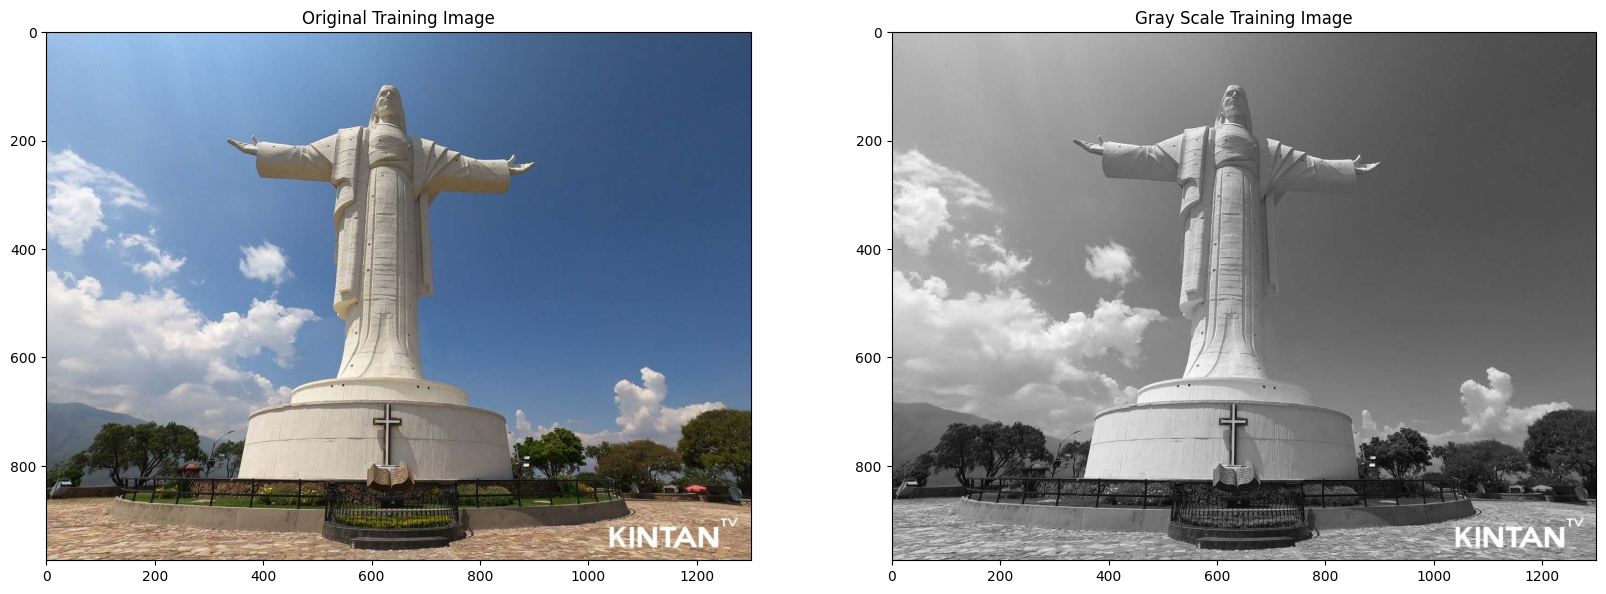

In [ ]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import os, requests

# Download the training image from the Internet
url = "https://kintan.tv/wp-content/uploads/2022/04/monumento-del-cristo-de-la-concordia.jpg"
img_data = requests.get(url, verify=False).content
with open(url.split("/")[-1], 'wb') as handler:
    handler.write(img_data)

# Load the training image
image = cv2.imread(url.split("/")[-1])

# Convert the training image to RGB
training_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the training image to gray Scale
training_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Set the default figure size
plt.rcParams['figure.figsize'] = [20,10]

# Display the images
plt.subplot(121)
plt.title('Original Training Image')
plt.imshow(training_image)
plt.subplot(122)
plt.title('Gray Scale Training Image')
plt.imshow(training_gray, cmap = 'gray')
plt.show()

### 2. Locating keypoints

The first step in the ORB algorithm is to locate all the keypoints in the training image. Then, ORB creates their corresponding binary feature vectors and groups them together in the ORB descriptor.

We will use OpenCV’s `ORB` class to locate the keypoints and create their corresponding ORB descriptor. The parameters of the ORB algorithm are setup by using the constructor function `ORB_create()`. Its parameters and default values are described below:


`cv2.ORB_create(nfeatures = 500,
               scaleFactor = 1.2,
		       nlevels = 8,
		       edgeThreshold = 31,
		       firstLevel = 0,
		       WTA_K = 2,
		       scoreType = HARRIS_SCORE,
		       patchSize = 31,
		       fastThreshold = 20)`
    
Parameters:

* **nfeatures** - *int*  
Determines the maximum number of features (keypoints) to locate.


* **scaleFactor** - *float*  
Pyramid decimation ratio, must be greater than 1. ORB uses an image pyramid to find features, therefore you must provide the scale factor between each layer in the pyramid and the number of levels the pyramid has. A `scaleFactor = 2` means the classical pyramid, where each next level has 4x less pixels than the previous. A big scale factor will diminish the number of features found.


* **nlevels** - *int*  
The number of pyramid levels. The smallest level will have a linear size equal to input_image_linear_size/pow(scaleFactor, nlevels).


* **edgeThreshold** - - *int*  
The size of the border where features are not detected. Since the keypoints have a specific pixel size, the edges of images must be excluded from the search. The size of the `edgeThreshold` should be equal to or greater than the patchSize parameter.


* **firstLevel** - *int*  
This parameter allows you to determine which level should be treated as the first level in the pyramid. It should be 0 in the current implementation. Usually, the pyramid level with a scale of unity is considered the first level.


* **WTA_K** - *int*  
The number of random pixels used to produce each element of the oriented BRIEF descriptor. The possible values are 2, 3, and 4, with 2 being the default value. For example, a value of 3 means three random pixels are chosen at a time to compare their brightness. The index of the brightest pixel is returned. Since there are 3 pixels, the returned index will be either 0, 1, or 2.


* **scoreType** - *int*  
This parameter can be set to either HARRIS_SCORE or FAST_SCORE. The default HARRIS_SCORE means that the Harris corner algorithm is used to rank features. The score is used to only retain the best features. The FAST_SCORE produces slightly less stable keypoints, but it is a little faster to compute.


* **patchSize** - *int*  
Size of the patch used by the oriented BRIEF descriptor. Of course, on smaller pyramid layers the perceived image area covered by a feature will be larger.


As we can see, the `cv2.ORB_create()`function supports a wide range of parameters. The first two arguments (`nfeatures` and ` scaleFactor`) are probably the ones you are most likely to change. The other parameters can be safely left at their default values. Read more about the parameters at: https://docs.opencv.org/3.4/db/d95/classcv_1_1ORB.html

In the code below, we will use the `ORB_create()`function to set the maximum number of keypoints to detect as 200, and set the pyramid decimation ratio as 2.1. We will then use the `.detectAndCompute(image)`method to locate the keypoints in the given training `image`and to compute their corresponding ORB descriptor.  Finally, we will use the ` cv2.drawKeypoints()` function to visualize the keypoints found by ORB.  

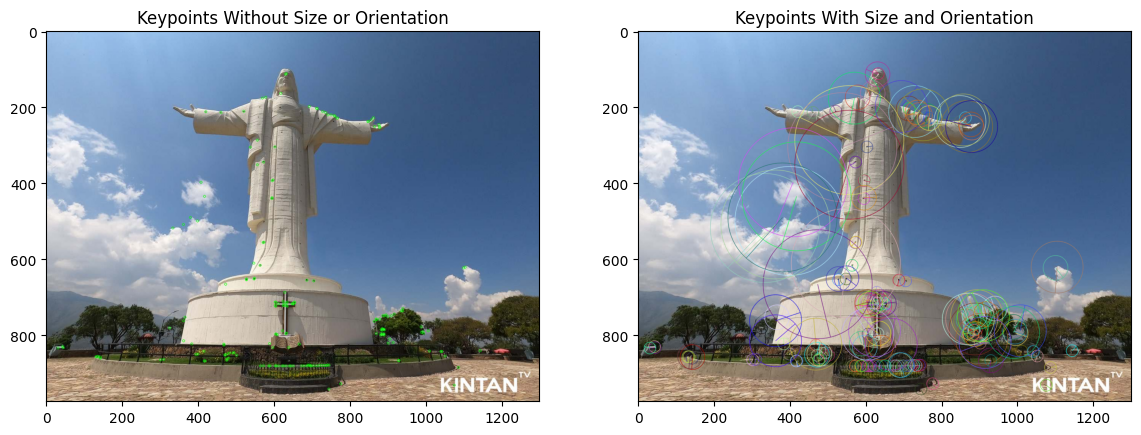


Number of keypoints Detected:  190


In [ ]:
# Import copy to make copies of the training image
import copy

# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio
orb = cv2.ORB_create(200, 2.1)

# Find the keypoints in the gray scale training image and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask.
keypoints, descriptor = orb.detectAndCompute(training_gray, None)

# Create copies of the training image to draw our keypoints on
keyp_without_size = copy.copy(training_image)
keyp_with_size = copy.copy(training_image)

# Draw the keypoints without size or orientation on one copy of the training image
cv2.drawKeypoints(training_image, keypoints, keyp_without_size, color = (0, 255, 0))

# Draw the keypoints with size and orientation on the other copy of the training image
cv2.drawKeypoints(training_image, keypoints, keyp_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Set the default figure size
plt.rcParams['figure.figsize'] = [14.0, 7.0]

# Display the image with the keypoints without size or orientation
plt.subplot(121)
plt.title('Keypoints Without Size or Orientation')
plt.imshow(keyp_without_size)

# Display the image with the keypoints with size and orientation
plt.subplot(122)
plt.title('Keypoints With Size and Orientation')
plt.imshow(keyp_with_size)
plt.show()

# Print the number of keypoints detected
print("\nNumber of keypoints Detected: ", len(keypoints))

As we can see in the right image, every keypoint has a center, a size, and an angle. The center determines the location of each keypoint in the image; the size of each keypoint is determined by the patch size used by rBRIEF to create its feature vector; and the angle tells us the orientation of the keypoint as determined by rBRIEF. Once the keypoints for the training image have been found and their corresponding ORB descriptor has been calculated, the same thing can be done for the query image.

###3. Feature matching

Once we have the ORB descriptors for *both* the training and query images, the final step is to perform keypoint matching between the two images using their corresponding ORB descriptors. This *matching* procedure is usually performed by a matching function. One of the most commonly-used matching functions is called *Brute-Force*.

In the code below, we will use OpenCV’s `BFMatcher` class to compare the keypoints obtained from the training and query images. The parameters of the Brute-Force matcher are setup using the constructor function `cv2.BFMatcher()`, which are explained below:

`cv2.BFMatcher(normType = cv2.NORM_L2,
		 	  crossCheck = false)`

Parameters:

* **normType**  
Specifies the metric used to determine the quality of the match. By default, we use `normType = cv2.NORM_L2` to measure the distance between two descriptors. However, for binary descriptors like the ones created by ORB, the Hamming metric is also suitable. The Hamming metric determines the distance by counting the number of dissimilar bits between the binary descriptors. When the ORB descriptor is created using `WTA_K = 2`, two random pixels are chosen and compared in brightness. The index of the brightest pixel is returned as either 0 or 1.  Such output only occupies 1 bit, and therefore the ` cv2.NORM_HAMMING` metric should be used.  If, on the other hand, the ORB descriptor is created using `WTA_K = 3`, three random pixels are chosen and compared in brightness. The index of the brightest pixel is returned as either 0, 1, or 2.  Such output will occupy 2 bits, and therefore a special variant of the Hamming distance, known as the `cv2.NORM_HAMMING2` (the 2 stands for 2 bits), should be used instead. Then, for any metric chosen, when comparing the keypoints in the training and query images, the pair with the smaller metric (distance between them) is considered a good match.


* **crossCheck** - *bool*
A Boolean variable and can be set to either `True` or `False`. Cross-checking is very useful for eliminating false matches. Cross-checking works by performing the matching procedure two times. The first time the keypoints in the training image are compared to those in the query image; the second time, however, the keypoints in the query image are compared to those in the training image (*i.e.* the comparison is done backwards). When cross-checking is enabled, a match is considered valid only if keypoint *A* in the training image is the best match of keypoint *B* in the query image and vice-versa (that is, if keypoint *B* in the query image is the best match of point *A* in the training image).

Read more about BGMatcher's parameters at: https://docs.opencv.org/3.4/d3/da1/classcv_1_1BFMatcher.html

Once the parameters of the *BFMatcher* have been set, we can use the `.match(descriptors_train, descriptors_query)` method to find the matching  keypoints between the training and query images by using their ORB descriptors. Finally, we will use the `cv2.drawMatches()` function to visualize the matching keypoints found by the Brute-Force matcher. This function stacks the training and query images horizontally and draws lines from the keypoints in the training image to their corresponding best matching keypoints in the query image.

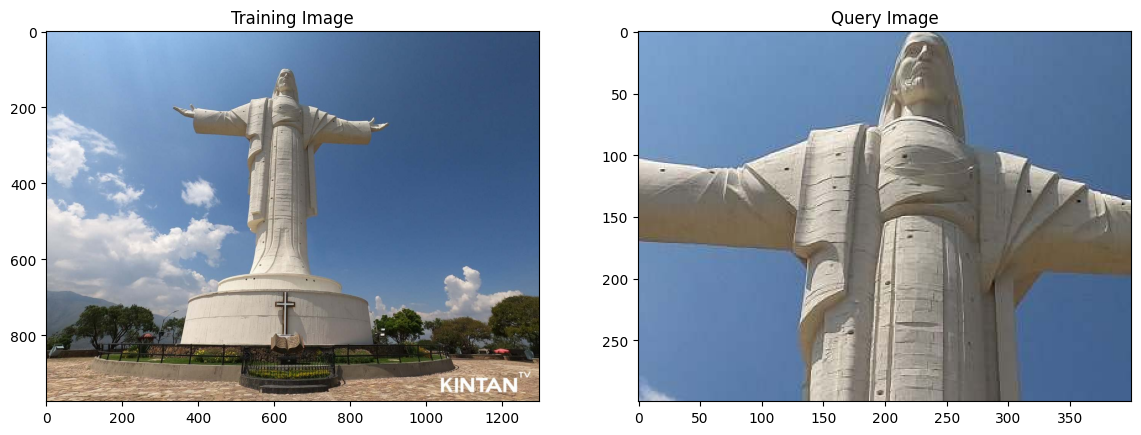

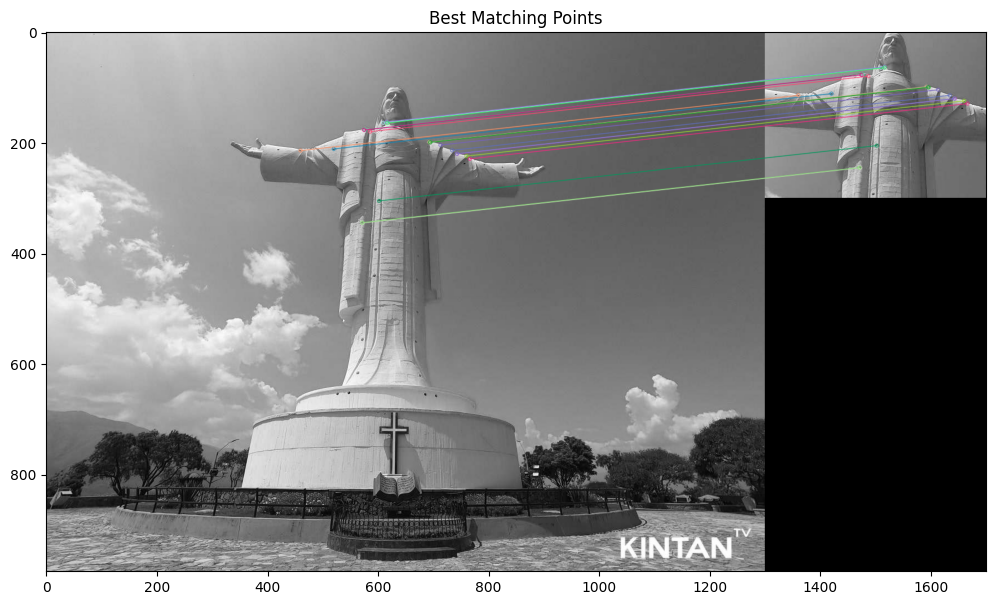

Number of Keypoints Detected In The Training Image:  500
Number of Keypoints Detected In The Query Image:  480

Number of Matching Keypoints Between The Training and Query Images:  130


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the training image
image1 = np.copy(image)
# Create a query image
image2 = image1[100:400,400:800]

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the query image to RGB
query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display the training and query images
plt.subplot(121)
plt.title('Training Image')
plt.imshow(training_image)
plt.subplot(122)
plt.title('Query Image')
plt.imshow(query_image)
plt.show()

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)

# Convert the query image to gray scale
query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

# Set the parameters of the ORB algorithm by specifying the maximum number of keypoints to locate and
# the pyramid decimation ratio
orb = cv2.ORB_create()

# Find the keypoints in the gray scale training and query images and compute their ORB descriptor.
# The None parameter is needed to indicate that we are not using a mask in either case.
keypoints_train, descriptor_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptor_query = orb.detectAndCompute(query_gray, None)

# Create a Brute Force Matcher object. Set crossCheck to True so that the BFMatcher will only return consistent
# pairs. Such technique usually produces best results with minimal number of outliers when there are enough matches.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the query image
matches = bf.match(descriptor_train, descriptor_query)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
matches = sorted(matches, key = lambda x : x.distance)

# Connect the keypoints in the training image with their best matching keypoints in the query image.
# The best matches correspond to the first elements in the sorted matches list, since they are the ones
# with the shorter distance. We draw the first 100 matches and use flags = 2 to plot the matching keypoints
# without size or orientation.
result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:20], query_gray, flags = 2)

# Set the default figure size
plt.rcParams['figure.figsize'] = [14.0, 7.0]

# Display the best matching points
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(keypoints_train))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(keypoints_query))

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

In the above example, since both the training and query images contain a similar car but in different locations, we expect that the same number of keypoints are found in both images. We can clearly see that the Brute-Force matcher has been able to correctly match 64 keypoints in both training and query images. Run the cells with a different couple of  images.

### 4. Saving descriptors in memory

In [ ]:
np.save("descriptor_train.npy", descriptor_train)
np.save("descriptor_query.npy", descriptor_query)

Retrieving descriptors

In [ ]:
r_descriptor_train = np.load("descriptor_train.npy")
r_descriptor_query = np.load("descriptor_query.npy")

# Create a Brute Force Matcher object. Set crossCheck to True so that the BFMatcher will only return consistent
# pairs. Such technique usually produces best results with minimal number of outliers when there are enough matches.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the ORB descriptors of the training image and the query image
matches = bf.match(r_descriptor_train, r_descriptor_query)

# The matches with shorter distance are the ones we want. So, we sort the matches according to distance
matches = sorted(matches, key = lambda x : x.distance)

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))


Number of Matching Keypoints Between The Training and Query Images:  130


As you can see, descriptors can be saved in memory for later use. After long time, you can query if a new image is inside a database using feature extraction. The paths to these descriptors should be included to dataframes, avoid including their content directly.

## **B. Handling of Visual Information with Pandas, Shutil, Glob, Path, and OS**

Pandas is an extension to Numpy and a Python library written for tabular data manipulation and analysis. In particular, it offers data structures and operations for manipulating tables with text, numbers, booleans, dates and others. Although this introduction will focus on two main data structures in Pandas: the Dataframe and the Series, you should also consider reviewing information about Panels. Series is usually used when filtering rows in Pandas. In the context of computer vision, Pandas will help us locate all images of a dataset and map them to additional files that might contain extra information: e.g. feature descriptors, segments, and annotations per image. In addition, Pandas will also help us perform **Exploratory Data Analysis (EDA)** with the objective of understanding the composition of a *dataset* in terms of image dimensions and labels. Therefore, this section will also make use of the libraries Shutil, OS, Glob, and Path, which are four libraries to move, copy, list, and delete files, among other file processing operations.
<center>
<img src='https://miro.medium.com/max/1400/0*Xhz01Vby2rg86xZj' width='50%'>
</center>

### 1. Introduction

A *Dataframe* has a structure very similar to tables, present in Excel or any relational database manager. Usually, *Dataframes* refer to objects or entities that may have several records, which will be recorded in row format. Additionally, each *Dataframe* can contain several columns, which are variables/attributes of what we want to record for each object or element. In Pandas, any data can be retrieved by its location at the intersection of row and column.

<center>
<img src='https://drive.google.com/uc?id=1Gh-e7URdrhF6Tu7_-utwQHsiOPiSQOnN' width='50%'></center>



### 2. Creating dataframes

There are several ways to create a dataframe, among them are:

- From a dictionary of lists
- From a list of lists
- From a list of dictionaries
- From a Numpy array
- From a CSV or Excel file

In this section, we will focus on creating a dataframe from a CSV file, and then, in section 6, we will do it from a dictionary with Series. To start, a CSV file contains tabular data, separated by commas. However, there is also the possibility of separating the data with tabulations. Usually, existing image datasets on the Internet have their annotations (categories for images, location of objects, or annotations for segmentation) in the CSV format. In the next cells, we will use this [CSV](https://drive.google.com/file/d/1oW9CGgoA4LIurFnw19OVoorytP19OoRF/view?usp=sharing) to show how Pandas works.

Note: A more exhaustive introduction to Pandas is available in the following [link](https://aprendeconalf.es/docencia/python/manual/pandas/).

In [ ]:
import numpy as np

# Import the Pandas library
import pandas as pd

# Useful libraries utiles para trabajar con archivos
import os
import shutil

# TQDM is useful for calculating the progress of an operation. e.g. applying canny to an entire dataset
from tqdm.auto import tqdm

# Library to work with mathematical procedures
import math
import random

# For the next lines, we will use several parameters to open a data set
# saved in CSV format, however, it is possible to leave them with their default value
#
# usecols = named list of columns
# index_col = column with the identifier of each record
# sep = separator with which the CSV file was registered, some options are: ';',',','_','\t'
col_list = ["ID", "Nombre","2016","2017","Crecimiento","Unidades","fecha","Activo"]
df = pd.read_csv('ejemplo_data.csv', index_col='ID', usecols=col_list, sep=',')

In [ ]:
# Show the first 5 rows of the dataframe, if you want to see the last five
# we can use df.tail(5)
df.head(5)

,Nombre,2016,2017,Crecimiento,Unidades,fecha,Activo
ID,,,,,,,
10002,Verde Mar,"$125,000.00",$162500.00,30.00%,500,1-10-2015,1
552278,Manantial sa,"$920,000.00","$101,2000.00",10.00%,700,6-23-2014,0
23477,ACME,"$50,000.00",62500.00,25.00%,125,3-12-2016,1
24900,Andes sur,"$350,000.00",490000.00,4.00%,75,10-28-2015,1
651029,San Pablo,"$15,000.00",$12750.00,-15.00%,No,2-15-2014,0


The following instructions allow us to display some attributes of the dataframe.

In [ ]:
print("Dimensions in rows and columns:", df.shape)
print("Number of elements: ", df.size)
print("Dataframe columns: ", df.columns)
print("Data types per column: ", df.dtypes)

Dimensions in rows and columns: (6, 7)
Number of elements:  42
Dataframe columns:  Index(['Nombre', '2016', '2017', 'Crecimiento', 'Unidades', 'fecha', 'Activo'], dtype='object')
Data types per column:  Nombre         object
2016           object
2017           object
Crecimiento    object
Unidades       object
fecha          object
Activo         object
dtype: object


In [ ]:
# Show a summary of the dataframe information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Nombre  12 non-null     object 
 1   Edad    12 non-null     int64  
 2   Nota    12 non-null     float64
 3   pesos   12 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 512.0+ bytes
None


### 3. Access and modification of values in a dataframe

One of the quickest ways to access some data is using the `iloc` and `loc` functions. Both are accesible from any Dataframe and Series. The main distinction between `loc` and `iloc` is that `loc` is based on column names and row indexes to retrieve a row, which means that you must specify rows and columns based on their row labels and column names. On the other hand, iloc is based on index positions, as we do in the case of arrays and lists.

In [ ]:
# Show the value located in the second row and third column,
# Note that this does not considers the 'ID' index column. Also, indexes start from 0.
print(df.iloc[1, 3])

10.00%


In [ ]:
# Show the value of the row with index 552278 and the column '2016'
print(df.loc[552278, '2016'])

$920,000.00


In [ ]:
# Modification of a data in the dataframe
df.loc[552278, '2016'] = "$123,456.00"

In [ ]:
df

,Nombre,2016,2017,Crecimiento,Unidades,fecha,Activo
ID,,,,,,,
10002,Verde Mar,"$125,000.00",$162500.00,30.00%,500,1-10-2015,1
552278,Manantial sa,"$123,456.00","$101,2000.00",10.00%,700,6-23-2014,0
23477,ACME,"$50,000.00",62500.00,25.00%,125,3-12-2016,1
24900,Andes sur,"$350,000.00",490000.00,4.00%,75,10-28-2015,1
651029,San Pablo,"$15,000.00",$12750.00,-15.00%,No,2-15-2014,0
651029,San Pablo,"-$15,000.00",$ 12750.00,-15.00%,No,2-15-2014,n


Deleting rows from a dataframe

In [ ]:
# Make a copy of the dataframe
df_copy = df.copy()

print(df_copy.shape)
# Delete rows 3 and 2
df_copy = df_copy.drop(df_copy.index[[3,2]])
print(df_copy.shape)
df_copy

(6, 7)
(4, 7)


,Nombre,2016,2017,Crecimiento,Unidades,fecha,Activo
ID,,,,,,,
10002,Verde Mar,"$125,000.00",$162500.00,30.00%,500,1-10-2015,1
552278,Manantial sa,"$123,456.00","$101,2000.00",10.00%,700,6-23-2014,0
651029,San Pablo,"$15,000.00",$12750.00,-15.00%,No,2-15-2014,0
651029,San Pablo,"-$15,000.00",$ 12750.00,-15.00%,No,2-15-2014,n


### 4. Data types with Pandas

The most common data types with which columns are defined are: *object*, *int64*, *float64*, *bool*, *datetime64*, *timedelta*, and *category*. The most used ones are explained below.

Numeric data types include integers (**int64**) and floating-point numbers (**float64**). If we have a column that contains both integers and floating point numbers, Pandas will assign the float data type to the entire column, so that the decimal points are not lost.

Also, unlike Python, the text data type in Pandas is known as an (**object**).

The boolean data type (**bool**) will contain values that can be True or False. In some occasions, it will be necessary to convert integer values 1s and 0s to their Boolean equivalent to process this data.

The category data type (**category**) can store a certain number of texts that will serve as classes or categories for a column.

Finally, Pandas has the date and time data type (**datetime64**), which will store values intended to contain time data.

In [ ]:
# Show the columns' types
df.dtypes

Nombre         object
2016           object
2017           object
Crecimiento    object
Unidades       object
fecha          object
Activo         object
dtype: object

### 5. Data type transformation

In the previous cell you can see that Pandas considers most of the columns as text, so it will be necessary to change the data type where required.

In [ ]:
# Change data type int64 to bool
df["Activo"] = df['Activo'].astype('bool')

In [ ]:
df.dtypes

Nombre         object
2016           object
2017           object
Crecimiento    object
Unidades       object
fecha          object
Activo           bool
dtype: object

In [ ]:
# Convert data type from object to category
df['Nombre']= df['Nombre'].astype('category')

In [ ]:
df.dtypes

Nombre         category
2016             object
2017             object
Crecimiento      object
Unidades         object
fecha            object
Activo             bool
dtype: object

In [ ]:
# Conversion of integer and float values should be done carefully, taking
# into account the notation with which they are registered.
# For example, in the previous section we could see that the 2016 column has values equal to
# '$125,000.00'. Applying the change: df['2016'].astype('float') would generate an error.
# In these cases, it's better to use an additional function to perform the variable conversion.

def convert_amount(val):
   ''' This function converts a value with commas, periods, and dollar signs to a
    floating value. '''
   new_data = val.replace(',','').replace('$', '')
   return float(new_data)

def convert_percentage(val):
   ''' This function converts a value with percentage signs to a
   floating number. '''
   new_data = val.replace('%', '')
   return float(new_data) / 100

# Apply the convert_amount and convert_percent function to the 2016, 2017, and Crecimiento columns
df['2016'] = df['2016'].apply(convert_amount)
df['2017'] = df['2017'].apply(convert_amount)
df['Crecimiento'] = df['Crecimiento'].apply(convert_percentage)

df.dtypes

Nombre         category
2016            float64
2017            float64
Crecimiento     float64
Unidades         object
fecha            object
Activo             bool
dtype: object

At this point, we still have to convert the Unidades column to numeric values and the fecha column to datetime64 type. However, the Unidades column has a non-numeric value, which we can evidence by applying the Pandas `to_numeric()` function.

In [ ]:
# Convert column to numeric values
# Parameters: the column to convert, and the behavior in the event of possible errors.
# Possible behaviors are: raise, or display an error; coerce, or define
# as NaN the values that cannot be converted to numeric; and ignore, or do nothing.
pd.to_numeric(df['Unidades'], errors='coerce')

ID
10002     500.0
552278    700.0
23477     125.0
24900      75.0
651029      NaN
651029      NaN
Name: Unidades, dtype: float64

Since we have a NaN value in the column, we can use the `fillna(0)` function to replace the values with NaN as 0s. This type of completion is called imputation and is part of a set of techniques for filling in missing data in a table.

In [ ]:
df["Unidades"]  = pd.to_numeric(df['Unidades'], errors='coerce').fillna(0)

In [ ]:
df.dtypes

Nombre         category
2016            float64
2017            float64
Crecimiento     float64
Unidades        float64
fecha            object
Activo             bool
dtype: object

In [ ]:
df

,Nombre,2016,2017,Crecimiento,Unidades,fecha,Activo
ID,,,,,,,
10002,Verde Mar,125000.0,162500.0,0.30,500.0,1-10-2015,True
552278,Manantial sa,123456.0,1012000.0,0.10,700.0,6-23-2014,True
23477,ACME,50000.0,62500.0,0.25,125.0,3-12-2016,True
24900,Andes sur,350000.0,490000.0,0.04,75.0,10-28-2015,True
651029,San Pablo,15000.0,12750.0,-0.15,0.0,2-15-2014,True
651029,San Pablo,-15000.0,12750.0,-0.15,0.0,2-15-2014,True


In [ ]:
# Convert a column of type object to datetime64
df['fecha']= pd.to_datetime(df['fecha'])

In [ ]:
df.dtypes

Nombre               category
2016                  float64
2017                  float64
Crecimiento           float64
Unidades              float64
fecha          datetime64[ns]
Activo                   bool
dtype: object

### 6. Basic Data Analysis

In addition to dataframes, Pandas also provides structures called *Series*. These are intended to store data in list or vector format, so they will usually have a single dimension. On the other hand, they can save data of only one type and their size is immutable, which means that they cannot be extended or reduced after their definition, but the content of a Series can be changed. This time we will use them to create a small dataset from code.

In [ ]:
# Define a dictionary with embedded data in 3 Series
d = {
     'Nombre':pd.Series(['Juan','Pedro','Ricardo','Viviana','Rosa','Soledad','Francisca',
    'Leandro','David','Mauricio','Esteban','Andrea']),
    'Edad':pd.Series([25,26,25,23,30,29,23,34,40,30,51,46]),
    'Nota':pd.Series([4.23,3.24,3.98,2.56,3.20,4.6,3.8,3.78,2.98,4.80,4.10,3.65])
      }

# Convert the dictionary to a new dataframe
df = pd.DataFrame(d)

In [ ]:
df

,Nombre,Edad,Nota
0,Juan,25,4.23
1,Pedro,26,3.24
2,Ricardo,25,3.98
3,Viviana,23,2.56
4,Rosa,30,3.20
5,Soledad,29,4.60
6,Francisca,23,3.80
7,Leandro,34,3.78
8,David,40,2.98
9,Mauricio,30,4.80


In [ ]:
# Get the average value of a column and reduce its number of decimal places to 2 with Numpy
print('Average Age: ', np.round(df['Edad'].mean(),2))

Average Age:  31.83


In [ ]:
# Obtain the weighted average of the Edad
df['pesos'] = pd.Series([1/20,1/20,1/20,1/20,1/20,1/20,1/20,1/20,1/20,1/20,5/20,5/20])

pond_formula = (df['Edad']*df['pesos']).sum()/df['pesos'].sum()
promedio_ponderado = np.average(df['Edad'], weights=df['pesos'])
print('Weighted average: ', promedio_ponderado)

Promedio ponderado:  38.5


In [ ]:
# Obtain the mode of the Edad column
df.Edad.mode()

0    23
1    25
2    30
Name: Edad, dtype: int64

In [ ]:
# Obtain the median of the Edad column
df.Nota.median()

3.79

In [ ]:
# Get the ranges of the Edad and Nota columns
print('Range for nota: ', np.round(df.Nota.max()-df.Nota.min(),2))
print('Range for edad: ', np.round(df.Edad.max()-df.Edad.min(),2))

Range for nota:  2.24
Range for edad:  28


In [ ]:
# Get the standard deviation of the Nota and Edad
print('std deviation nota: ', np.round(df.Nota.std(),2))
print('std deviation edad: ', np.round(df.Edad.std(),2))

std deviation nota:  0.66
std deviation edad:  9.23


In [ ]:
# Get the variance of the grade and age
print('Nota variance: ', np.round(df.Nota.var(),2))
print('Edad variance: ', np.round(df.Edad.var(),2))

Nota variance:  0.44
Edad variance:  85.24


In [ ]:
# Get the lower, middle and upper quantiles of Edad and Nota
df[['Edad', 'Nota']].quantile([0.25,0.5,0.75])

,Edad,Nota
0.25,25.0,3.2300
0.50,29.5,3.7900
0.75,35.5,4.1325


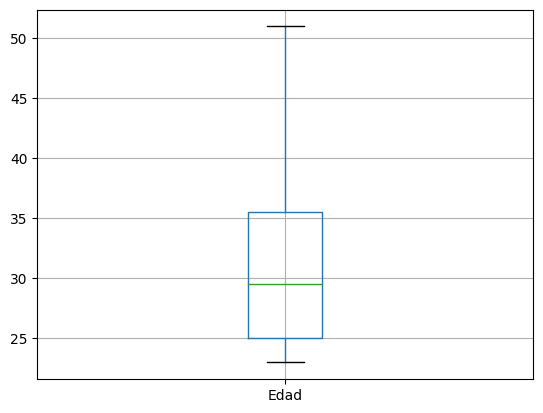

In [ ]:
# Create the boxplot for the age column
import matplotlib.pyplot as plt
plot = df[['Edad', 'Nombre']]
plot.boxplot()
plt.show()

In [ ]:
# Get the covariance of the dataframe
df.cov()

<ipython-input-37-0ec4776151d3>:2: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.cov()


,Edad,Nota,pesos
Edad,85.242424,0.357879,0.606061
Nota,0.357879,0.437752,0.004788
pesos,0.606061,0.004788,0.006061


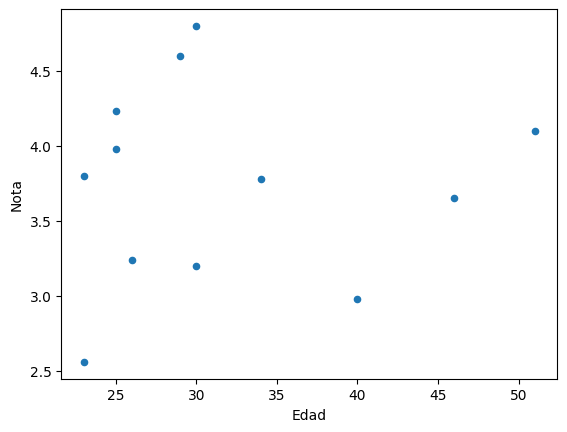

In [ ]:
# Create graph of age, with respect to grade
df.plot.scatter(x='Edad', y='Nota')
plt.show()

### 7. Process an image dataset

From this section we will focus on working with an image dataset that comes from the well-known  [Kaggle](https://www.kaggle.com/) repository. This is a free platform that has a series of challenges available for users to solve with topics such as data science, predictive analysis and machine learning. Also, it contains an infinite number of datasets open to the public for processing and analysis.

#### Download dataset from Kaggle

The dataset we will work with is called "City Problems Dataset". This contains images of issues in urban environments, specifically 23,877 full-color images (2 Gb), of which only 15,223 images have a label. The rest is oriented towards the testing stage of a computer vision algorithm.

This data set includes 8 classes:

- **Class 0:** no event
- **Class 1:** fallen tree
- **Class 2:** fire
- **Class 3:** flood
- **Class 4:** wrong path
- **Class 5:** traffic jam
- **Class 6:** garbage
- **Class 7:** traffic accident

In [ ]:
# Define the credentials to access Kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# You can create your own API token and username on the Kaggle platform
# you must change the following information to your account information
api_token = {"username":"edwinsalcedo","key":""}

import json

# Create a file with the credentials so that Kaggle can easily access it.
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%cd /content

# Check if the dataset has already been downloaded
if not os.path.exists('./city_problems'):
   os.makedirs('city_problems')
else:
   !rm -rf city_problems

# Download the dataset from Kaggle
!kaggle datasets download -d tunhunhminh/demodata -p city_problems

# Decompress the dataset
!unzip -qn '/content/city_problems/demodata.zip' -d /content/city_problems > /dev/null
!rm /content/city_problems/demodata.zip

/content
100% 1.89G/1.89G [01:08<00:00, 29.0MB/s]
100% 1.89G/1.89G [01:08<00:00, 29.9MB/s]


#### Sort the dataset

Ok, the dataset is downloaded, but not ready to be used with Deep Learning models 🧐. Eventually, you will have to move files and sort out folders to prepare the dataset for your computer vision system. Also, file management will be important when exploring the data through EDAs. Currently, the downloaded dataset contains two folders with images, one for the train subset and another for the test subset. In both folders you can find images with .jpeg, .jpg, and .png extensions. On the other hand, the folder also has a CSV file for the train subset and another for the test subset. These files contain a label for each image, so they could be quite useful to implement a deep learning model to classify the images into the respective categories: no event, fallen tree, fire, flood, bad road, traffic jam , garbage, and traffic accident.

For instance, some TensorFlow models require to reorganize the dataset into two separate folders (train and test), in which one should create a folder for each of the existing categories in the dataset. We'll complete this in the following cell.

In [ ]:
# Sklearn has a tool to split a dataset
# into a training subset and an testing subset
# Both are important to work with machine learning models
from sklearn.model_selection import train_test_split

TRAINSET_PATH = "/content/train_data"
TESTSET_PATH = "/content/test_data"
categories = ["no_event","fallen_tree","fire","flooding","bad_road","traffic_jam","garbage","traffic_accident"]

dataset = pd.read_csv('/content/city_problems/train.csv')

# Split the data set into training and testing subsets with Scikit-learn
train, test = train_test_split(dataset, test_size=0.2)

train["image_path"] = " "
test["image_path"] = " "

def sort_subset(subset, target_path):
   ''' This function distributes images from one folder to multiple
       folders, this based on the categories to which the images belong.
   '''
   # Check if the new folders for the organized dataset have already been created
   if os.path.exists(target_path):
     !rm -rf "$target_path"

   !mkdir "$target_path"
   dirs = {}

   # Move each image to its respective folder
   for idx, category in enumerate(categories):
     !mkdir "$target_path/$category"
     dirs[idx] = target_path+"/"+category

   for idx, sample in tqdm(subset.iterrows(), total=len(subset)):
     image_name = subset.at[idx,"image_id"]
     category = subset.at[idx,"label"]

     new_path = dirs[category]+"/"+image_name

     shutil.copy("/content/city_problems/train/train/"+image_name,new_path)
     subset.at[idx,"image_path"] = new_path

   print("Done!", target_path)
   return subset

train = sort_subset(train,TRAINSET_PATH)
test = sort_subset(test,TESTSET_PATH)

train = train.reset_index()
test = test.reset_index()

  0%|          | 0/12178 [00:00<?, ?it/s]

Done! /content/train_data


  0%|          | 0/3045 [00:00<?, ?it/s]

Done! /content/test_data


In [ ]:
# Show the new folder organization in the train_data and test_data folders
print(os.listdir(TRAINSET_PATH))
print(os.listdir(TESTSET_PATH))

['fire', 'no_event', 'garbage', 'bad_road', 'fallen_tree', 'flooding', 'traffic_jam', 'traffic_accident']
['fire', 'no_event', 'garbage', 'bad_road', 'fallen_tree', 'flooding', 'traffic_jam', 'traffic_accident']


#### Visualize a set of images

Although frequently underrated, creating a function to show random samples from your dataset is crucial to understanding its composition. Even better, you can also show information about labels, bounding boxes, masks, and so on, to understand the annotations of a dataset. Moreover, executing such a function should be repeated several times to find problems with the dataset.

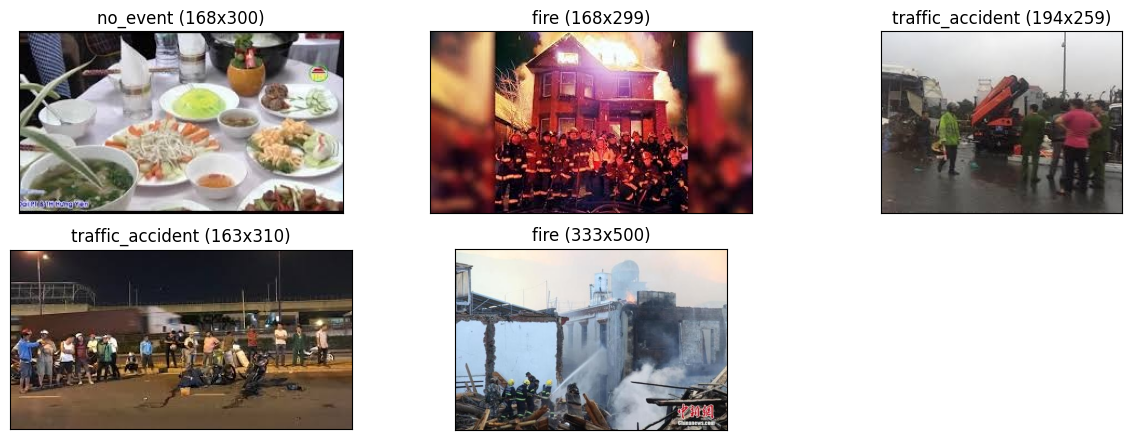

In [ ]:
import cv2

def visualize(image_array):
   plt.rcParams["figure.figsize"] = (15,8)

   for index, sample in enumerate(image_array):
     img = cv2.imread(sample[0])
     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

     plt.subplot(3, 3, index+1), plt.imshow(img)
     plt.title(sample[1]+" ("+str(img.shape[0])+"x"+str(img.shape[1])+")")
     plt.xticks([]), plt.yticks([])

random_category = random.randint(0,len(categories)-1)
images = []
num_images = 5

for num in range(num_images):
   random_image = random.randint(0,len(train)-1)
   images.append([train.at[random_image,"image_path"],categories[train.at[random_image,"label"]]])

visualize(images)

In [ ]:
print(train)

       index   image_id  label                                image_path
0       5325   5325.jpg      2         /content/train_data/fire/5325.jpg
1       5896   5896.jpg      2         /content/train_data/fire/5896.jpg
2      12318  12318.jpg      6     /content/train_data/garbage/12318.jpg
3       3567   3567.jpg      1  /content/train_data/fallen_tree/3567.jpg
4       5553   5553.jpg      2         /content/train_data/fire/5553.jpg
...      ...        ...    ...                                       ...
12173  12206  12206.jpg      6     /content/train_data/garbage/12206.jpg
12174   6198   6198.jpg      2         /content/train_data/fire/6198.jpg
12175   3600   3600.jpg      1  /content/train_data/fallen_tree/3600.jpg
12176   7176   7176.jpg      3     /content/train_data/flooding/7176.jpg
12177  12620  12620.jpg      6     /content/train_data/garbage/12620.jpg

[12178 rows x 4 columns]


#### Create the CSV from scratch

Let's imagine that your dataset doesn't contain a CSV file. Sometimes, images in datasets can have their labels embedded in their names. e.g. fire34.jpg (class), fire34_34_56_67_90.jpg (class & bounding box). Then, it will be important to map all files and try to retrieve the embedded labels in it.

In [ ]:
import os
# Glob is a library tha contains many useful functions to work with files. One
# of them is .glob(), which helps you list files using regular expressions. E.g. *.*
import glob
# Path is a library that let us interact directly with full directory paths
# We program with PosixPath objects and the library translate them to the format used in the host OS
# Sometimes we still need the path to be a string, then we should convert it with the str() function
from pathlib import Path

# Extract all folders containing images per category
DATASET_PATH = Path("/content/train_data/")
category_paths = [str(DATASET_PATH/image) for image in os.listdir(DATASET_PATH)] # Note the structure used in one line to retrieve all folders
print(category_paths)

# Extract the full path to the images inside the dataset with glob.glob
labels = {'fire':0, 'no_event':1, 'garbage':2, 'bad_road':3, 'fallen_tree':4, 'flooding':5, 'traffic_jam':6, 'traffic_accident':7}

image_paths = []
image_ids = []
extensions = []
categories = []

for image in glob.glob(str(DATASET_PATH/"*"/"*.*")): # Note that we can specify the format here. For example: *.jpeg
  file_name = image.split("/")[-1]
  categories.append(labels[image.split("/")[-2]])
  extensions.append(file_name.split(".")[1])
  image_ids.append(file_name.split(".")[0])
  image_paths.append(image)

data = pd.DataFrame(list(zip(image_ids, image_paths,extensions,categories)),
               columns =['ID', 'path', 'extension', 'category'])

data

# Now, you can download the dataframe as a CSV file

['/content/train_data/fire', '/content/train_data/no_event', '/content/train_data/garbage', '/content/train_data/bad_road', '/content/train_data/fallen_tree', '/content/train_data/flooding', '/content/train_data/traffic_jam', '/content/train_data/traffic_accident']


,ID,path,extension,category
0,6326,/content/train_data/fire/6326.jpg,jpg,0
1,5961,/content/train_data/fire/5961.jpg,jpg,0
2,5518,/content/train_data/fire/5518.jpg,jpg,0
3,5133,/content/train_data/fire/5133.jpg,jpg,0
4,6185,/content/train_data/fire/6185.jpg,jpg,0
...,...,...,...,...
12173,13895,/content/train_data/traffic_accident/13895.jpg,jpg,7
12174,13420,/content/train_data/traffic_accident/13420.jpg,jpg,7
12175,14842,/content/train_data/traffic_accident/14842.jpg,jpg,7
12176,14051,/content/train_data/traffic_accident/14051.jpg,jpg,7


## **Exercise 1:** Feature extractors

Although ORB is well known for being faster than other feature extractors, it has problems with some image variations, such as rotation and illumination. In such cases, it's a good idea to try different feature extraction methods and compare their results according to the found features and matches.

This time, you will have to implement ORB, SIFT, AKAZE, BRISK, KAZE, and AGAST to find and match the keypoints of a training image and a query image. The images should be related to a famous building in Bolivia, however, most importantly, you should use two different pictures of the same building with different perspective. You also have to test the FLANN Feature Matcher, known for its better performance. Use the following link to understand the OpenCV implementations: https://docs.opencv.org/master/db/d27/tutorial_py_table_of_contents_feature2d.html

SIFT and the other feature extractors might not be available for all OpenCV versions. Possibly, you will have to uninstall your current OpenCV version and install another version. For example, SIFT is available in `opencv-contrib-python==3.4.16.59` and `4.7.0.72`, which can be installed as follows.

```
!pip uninstall opencv-python
!pip uninstall opencv-contrib-python
!pip install opencv-contrib-python==3.4.16.59
```

In the end, you should obtain a table similar to the following:

\begin{array}{ccccccc}
\text{Feature Extractor}&\text{Features found in Training Image}&\text{Features found in Query Image}&\text{Matches with BF}&\text{Matches with FLANN}&\text{Correct matches}\\
SIFT              &                                  &                               &                 &                    &                 \\
ORB               &                                  &                               &                 &                    &                 \\
AGAST             &                                  &                               &                 &                    &  \\
AKAZE             &                                  &                               &                 &                    &  \\
AKAZE             &                                  &                               &                 &                    &      \\
BRISK             &                                  &                               &                 &                    &        \\
\end{array}

Try obtain the best results as possible varying the method's parameters. Finally, note that you have to count manually the correct keypoints matched in both images to fill in the final column.

## **Exercise 2:** Noise invariance
Let's test the methods with noisy images! You will now have to apply the previous feature extraction methods with:
1. a noisy query image (apply Salt and pepper)
2. a rotated query image
3. a darker or brighter query image

Instead of repeating your code, try to create functions. Which method performs better to match key points? Show a table summarising your findings for the three cases. You can use only a matcher this time.

## **Exercise 3:** Attendance system
Lecturers are used to checking attendance saying loudly the students' names. This practice takes time, so let's try to automate it considering that nobody in a class is wearing masks.

You will have to implement a way to verify if a person is present in a picture using the feature detection methods. Also, you will have to collect your data: individual profile pictures of students and a bigger picture with the presence of all students. You will have to test which  feature extraction algorithm and feature matching algorithm performs better in two sceneries:
- All students looking at the camera, which will be useful to test similarity with their profile pictures.
- All students looking in different directions.

You can download a picture of a lecture from Youtube or the Internet and extract the individual pictures with slicing. In order to get variations of these pictures, you can apply transformations such as rotation, reflection, affine, or translation.

Try to create a table similar to the one asked in Exercise 1.

## **Exercise 4:** EDA 1
This exercise requires you to implement your image processing knowledge and a different dataset available [here](https://drive.google.com/file/d/1kpiSyUeyhNgAaGCZoIZO6Fxp4FUtdP2p/view?usp=sharing). You will need to upload it to your notebook and perform the next steps:

0. Create a dataframe mapping the images and annotations
1. Extract the luminosity inside each image, include in the dataframe, and create a function to show the lightest and darkest image using the dataframe.
2. Apply CLAHE and create a new column in the dataframe with the corresponding routes of the new samples.
3. Obtain the dimensions (width and height) of the images and save them in separate columns. Create a function that accepts a dataframe and shows a vertical bar plot with the existing dimensions. In the event that there were many variants, you can show the 5 most frequent.
4. Create a histogram or bar plot to show the number of images per category.

## **Exercise 5:** EDA 2

Download a new public dataset from the website [Roboflow](https://universe.roboflow.com/) and solve the following exercises by creating functions. The unique rule is that the dataset should be for **object detection**. The datasets for this task contain annotations in XML, TXT, or JSON format.

0. Create a dataframe that contains one row for each image in the dataset. The record will have to be composed by an image path, an annotation path, and the image's height and width.
1. Create a dataframe with all bounding boxes (coordinates x1, y1, x2, y2) and their category  specifying in a column the image id.
2. Show a histogram with the labels present in the dataset.
3. Show an image sample per category present in the dataset and draw their bounding boxes in them.
4. Generate a plot with the size distribution (height and width of the images), similar to the one carried out in the previous exercise.
5. Extract the keypoints by image (use the method of your preference) and save them in a separate folder. It will be important to include the file paths as an additional column in the dataframe.
6. Create a function to display an image, its bounding boxes and the extracted keypoints in the previous step. Note that you must show the keypoints extracted in step 5.

## **Exercise 6:** EDA 3


The datasets explored up to this point were oriented towards the task of classification and object detection (with categories and/or bounding boxes defined by two pairs of coordinates that frame an object). However, tasks such as semantic segmentation and instance segmentation require working with pixel-level information. Consequently, these datasets include a mask per image. Other times, you find a unique json file with segments defined as polygons.


In this exercise you will have to work with the dataset [⚽ Football Player Segmentation ⚽](https://www.kaggle.com/datasets/ihelon/football-player-segmentation), which contains a json file `instances_default.json`. This must be read with the `json` or `ujson` library and its content must be registered in one or more dataframes, with which the following information can be obtained:

1. Maximum and minimum number of players in an image. Show the respective images.
2. Number of categories and their frequency in the dataset
3. Dimensions (width and height) present in the dataset
4. A function to randomly display an image with the players marked with a different color.